In [2034]:
#| hide
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../DropGAT')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.display import Markdown as md
import pdb #pdb.set_trace()

In [3010]:
%matplotlib inline

import numpy as np
import torch
from torch.autograd import Variable
import random
import math

import matplotlib.pyplot as plt
from tqdm import trange
import GPy

501


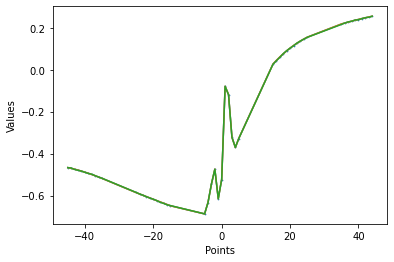

In [3039]:
#seed_custom = random.randint(1, 1000)  # 1부터 100 사이의 임의의 정수
np.random.seed(696) #560 275 724 567 731 993
print(seed_custom)

sample_size = 1
range_size = 1
dense_size = 10
realization_number = 100
realization_size = 1

points = np.linspace(-45, -35, dense_size * sample_size + 1)[:-1]
points = np.append(points,np.linspace(-35, -25, sample_size + 1)[:-1])
points = np.append(points,np.linspace(-25, -15, dense_size * sample_size + 1)[:-1])
points = np.append(points,np.linspace(-15, -5, sample_size + 1)[:-1])
points = np.append(points,np.linspace(-5, 5, dense_size * sample_size + 1)[:-1])
points = np.append(points,np.linspace(5, 15, sample_size + 1)[:-1])
points = np.append(points,np.linspace(15, 25, dense_size * sample_size + 1)[:-1])
points = np.append(points,np.linspace(25, 35, sample_size + 1)[:-1])
points = np.append(points,np.linspace(35, 45, dense_size * sample_size + 1)[:-1])
points = points.reshape(-1,1)

kernel_1 = GPy.kern.MLP(input_dim=1)#,  active_dims=[0])
mean_vector_1 = np.zeros(points.shape[0])
covariance_matrix_1 = kernel_1.K(points, points)
realizations_1 = np.random.multivariate_normal(mean_vector_1, covariance_matrix_1, realization_number).transpose()

'''
kernel_2 = GPy.kern.MLP(input_dim=1)#,  active_dims=[0])
mean_vector_2 = np.zeros(realizations_1.shape[0])
covariance_matrix_2 = kernel_2.K(realizations_1,realizations_1)
realizations_2 = np.random.multivariate_normal(mean_vector_2, covariance_matrix_2, 1).transpose()


kernel_3 = GPy.kern.MLP(input_dim=1)#,  active_dims=[0])
mean_vector_3 = np.zeros(realizations_2.shape[0])
covariance_matrix_3 = kernel_3.K(realizations_2,realizations_2)
realizations_3 = np.random.multivariate_normal(mean_vector_3, covariance_matrix_3, 1).transpose()
'''

mean_vector_final = realizations_1
realizations_final = np.random.multivariate_normal(mean_vector_final[:,0], (1/1000000)*np.identity(mean_vector_final.shape[0]), realization_size).T

points_append = points
for i in range(realization_size-1):
    points_append = np.append(points_append,points)
realizations = realizations_final[:,0]
for i in range(realization_size-1):
    realizations = np.append(realizations,realizations_final[:,i+1])

plt.plot(points[:], mean_vector_final[:,0])

points.shape

plt.plot(points[:], mean_vector_final[:,0])
for index in range(realization_size):
    plt.plot(points[:], realizations_final[:,index]);
plt.xlabel('Points');
plt.ylabel('Values');

plt.scatter(points, realizations_final[:,0], s = 0.5);

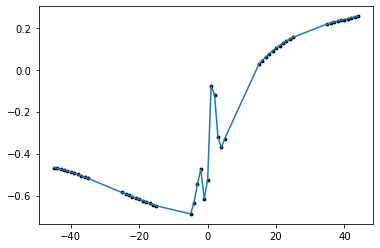

In [3040]:
plt.plot(points[:], mean_vector_final[:,0])
for index in range(realization_size):
    plt.scatter(points[:], realizations_final[:,index], s = 8, c="black");
#plt.savefig('full.pdf')

In [3041]:
l2 = 0.01
X_obs = points_append[:,0]
y_obs = realizations
X_true = np.arange(-90, 90, 0.1)
N = X_obs.shape[0]
X_mean, X_std = X_obs.mean(), X_obs.std()
y_mean, y_std = y_obs.mean(), y_obs.std()
X_obs = (X_obs - X_mean) / X_std
y_obs = (y_obs - y_mean) / y_std
X_true = (X_true - X_mean) / X_std

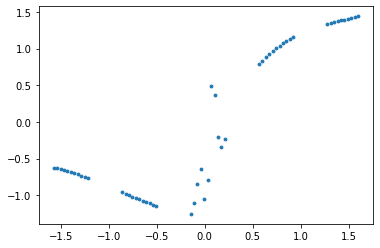

In [3042]:
plt.scatter(X_obs,y_obs, s = 8);
plt.savefig('full.pdf')

In [3043]:
class SimpleModel(torch.nn.Module):
    def __init__(self, p, decay):
        super(SimpleModel, self).__init__()
        self.dropout_p = p
        self.decay = decay
        self.f = torch.nn.Sequential(
            torch.nn.Linear(1,2000),
            torch.nn.Dropout(p=self.dropout_p),
            torch.nn.Linear(2000, 2000),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=self.dropout_p),
            torch.nn.Linear(2000,1)
        )
    def forward(self, X):
        X = Variable(torch.Tensor(X), requires_grad=False)
        return self.f(X)

In [3044]:
model = SimpleModel(p=0.2, decay=1e-5)

In [3045]:
def uncertainity_estimate(X, model, iters, l2):
    outputs = np.hstack([model(X[:, np.newaxis]).data.numpy() for i in trange(iters)])
    y_mean = outputs.mean(axis=1)
    y_variance = outputs.var(axis=1)
    tau = l2 * (1. - model.dropout_p) / (2. * N * model.decay)
    y_variance += (1. / tau)
    y_std = np.sqrt(y_variance)
    return y_mean, y_std

In [3046]:
def plot_model(model, l2, iters=1000, n_std=2, ax=None):
    if ax is None:
        plt.close("all")
        plt.clf()
        fig, ax = plt.subplots(2,1)
        fig = plt.figure(figsize=(10, 15))
    y_mean, y_std = uncertainity_estimate(X_true, model, iters, l2)
    
    ax[0].plot(X_obs, y_obs, ls="none", marker="o", color="0.1", alpha=0.8, label="observed")
    ax[0].plot(X_true, y_mean, ls="-", color="b", label="mean")
    for i in range(n_std):
        ax[0].fill_between(
            X_true,
            y_mean - y_std * ((i+1.)/2.),
            y_mean + y_std * ((i+1.)/2.),
            color="b",
            alpha=0.1
        )
    ax[0].legend()
    ax[1].plot(X_true, y_std, ls="-", color="b", label="mean")
    #plt.savefig('drop_full.png')
    return ax

In [3047]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(
    model.parameters(), lr=0.01,
    weight_decay=model.decay)

In [3048]:
def fit_model(model, optimizer):
    y = Variable(torch.Tensor(y_obs[:, np.newaxis]), requires_grad=False)
    y_pred = model(X_obs[:, np.newaxis])
    optimizer.zero_grad()
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    return loss

100%|█████████████████████████████████████████████████████████████████████| 10000/10000 [00:43<00:00, 231.75it/s]


loss=0.05539202690124512


100%|████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.06it/s]


'\nfor i in range(2):\n    ax0.fill_between(\n        X_true,\n        y_mean - y_std * ((i+1.)/2.),\n        y_mean + y_std * ((i+1.)/2.),\n        color="b",\n        alpha=0.1\n    )\n'

Text(0, 0.5, 'Y')

Text(0, 0.5, 'MC sample variance')

Text(0.5, 0, 'X')

<Figure size 432x288 with 0 Axes>

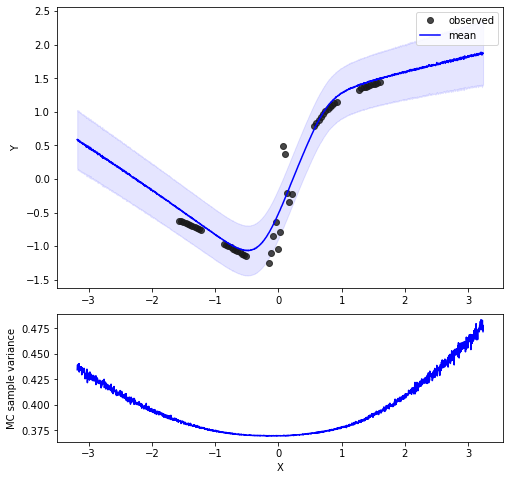

In [3049]:
plt.close("all")
plt.clf()
fig = plt.figure(figsize=(8, 8))
ax0 = plt.subplot2grid((3,1), (0, 0), rowspan=2)
ax1 = plt.subplot2grid((3,1), (2, 0))
losses = []
for i in trange(10000):
    loss = fit_model(model, optimizer)
    losses.append(loss.data.numpy())
print("loss={}".format(loss))

y_mean, y_std = uncertainity_estimate(X_true, model, 1000, l2)

ax0.plot(X_obs, y_obs, ls="none", marker="o", color="0.1", alpha=0.8, label="observed")
ax0.plot(X_true, y_mean, ls="-", color="b", label="mean")

ax0.fill_between(
    X_true,
    y_mean - y_std,
    y_mean + y_std,
    color="b",
    alpha=0.1
)
ax0.legend()
ax1.plot(X_true, y_std, ls="-", color="b", label="mean")
ax0.set_ylabel("Y")
ax1.set_ylabel("MC sample variance")
ax1.set_xlabel("X")
plt.savefig('drop_full.pdf')

Optimization restart 1/10, f = -142.2495744078833
Optimization restart 2/10, f = -146.84715421192914
Optimization restart 3/10, f = -146.84715419540774
Optimization restart 4/10, f = -146.84715417519445
Optimization restart 5/10, f = -146.84715424605665
Optimization restart 6/10, f = -146.84715388777536
Optimization restart 7/10, f = -146.8471541985314
Optimization restart 8/10, f = -146.8194055316584
Optimization restart 9/10, f = -141.7364391394052
Optimization restart 10/10, f = -146.84715421912568


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0003  -1.468472e+02   3.758516e-10 
    00s03  0012  -1.468472e+02   1.916671e-09 
Runtime:     00s03
Optimization status: Converged



 /nix/store/fngb2z93lyss8cvmflnkn3rmkvgkx1zr-python3-3.9.15-env/lib/python3.9/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Text(0, 0.5, 'Y')

Text(0, 0.5, 'posterior variance')

Text(0.5, 0, 'X')

{'dataplot': [<matplotlib.collections.PathCollection at 0x7f75127bfdf0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7f7509ae3760>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7f7509ae3970>]}

(-2.6, 3.1)

<Figure size 432x288 with 0 Axes>

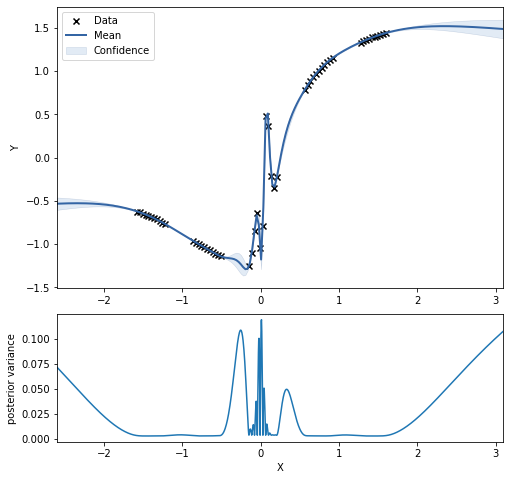

In [3051]:
kernel = GPy.kern.MLP(input_dim=1)
m1 = GPy.models.GPRegression(np.expand_dims(X_obs, axis=1), np.expand_dims(y_obs, axis=1), kernel=kernel)
m1.optimize_restarts(num_restarts = 10)
m1.optimize(messages=True)

import matplotlib
matplotlib.use("Agg")
GPy.plotting.change_plotting_library("matplotlib")

plt.close("all")
plt.clf()
fig = plt.figure(figsize=(8, 8))
ax0 = plt.subplot2grid((3,1), (0, 0), rowspan=2)
ax1 = plt.subplot2grid((3,1), (2, 0))
ax0.set_ylabel("Y")
ax1.set_ylabel("posterior variance")
ax1.set_xlabel("X")
m1.plot(ax=ax0,plot_limits = [-2.6,3.1], lower=15.9, upper=84.1)
mean, var = m1.predict(np.expand_dims(X_true, axis=1))
ax1.plot(X_true,np.sqrt(var))
ax1.set_xlim(-2.6,3.1)
plt.savefig("gp_full.pdf")

In [3052]:
type(var)

numpy.ndarray

In [3053]:
points_append.shape

(54, 1)

In [3054]:
l2 = 0.01
X_obs = np.append(points_append[:,0][:20],points_append[:,0][44:])
y_obs = np.append(realizations[:20],realizations[44:])
X_true = np.arange(-90, 90, 0.1)
N = X_obs.shape[0]
X_mean, X_std = X_obs.mean(), X_obs.std()
y_mean, y_std = y_obs.mean(), y_obs.std()
X_obs = (X_obs - X_mean) / X_std
y_obs = (y_obs - y_mean) / y_std
X_true = (X_true - X_mean) / X_std

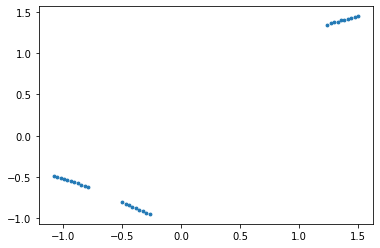

In [3055]:
plt.scatter(X_obs,y_obs, s = 8);
plt.savefig('part.pdf')

In [3056]:
class SimpleModel(torch.nn.Module):
    def __init__(self, p, decay):
        super(SimpleModel, self).__init__()
        self.dropout_p = p
        self.decay = decay
        self.f = torch.nn.Sequential(
            torch.nn.Linear(1,2000),
            torch.nn.Dropout(p=self.dropout_p),
            torch.nn.Linear(2000, 1000),
            torch.nn.ReLU(),
            #torch.nn.Dropout(p=self.dropout_p),
            #torch.nn.Linear(2000, 2000),
            #torch.nn.ReLU(),
            torch.nn.Dropout(p=self.dropout_p),
            torch.nn.Linear(1000,1)
        )
    def forward(self, X):
        X = Variable(torch.Tensor(X), requires_grad=False)
        return self.f(X)

In [3057]:
model = SimpleModel(p=0.2, decay=1e-5)

In [3058]:
def uncertainity_estimate(X, model, iters, l2):
    outputs = np.hstack([model(X[:, np.newaxis]).data.numpy() for i in trange(iters)])
    y_mean = outputs.mean(axis=1)
    y_variance = outputs.var(axis=1)
    tau = l2 * (1. - model.dropout_p) / (2. * N * model.decay)
    y_variance += (1. / tau)
    y_std = np.sqrt(y_variance)
    return y_mean, y_std

In [3059]:
def plot_model(model, l2, iters=1000, n_std=2, ax=None):
    if ax is None:
        plt.close("all")
        plt.clf()
        fig, ax = plt.subplots(2,1)
        fig = plt.figure(figsize=(10, 15))
    y_mean, y_std = uncertainity_estimate(X_true, model, iters, l2)
    
    ax[0].plot(X_obs, y_obs, ls="none", marker="o", color="0.1", alpha=0.8, label="observed")
    ax[0].plot(X_true, y_mean, ls="-", color="b", label="mean")
    for i in range(n_std):
        ax[0].fill_between(
            X_true,
            y_mean - y_std * ((i+1.)/2.),
            y_mean + y_std * ((i+1.)/2.),
            color="b",
            alpha=0.1
        )
    ax[0].legend()
    ax[1].plot(X_true, y_std, ls="-", color="b", label="mean")
    #plt.savefig('drop_full.png')
    return ax

In [3060]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(
    model.parameters(), lr=0.01,# momentum=0.,
    weight_decay=model.decay)

In [3061]:
def fit_model(model, optimizer):
    y = Variable(torch.Tensor(y_obs[:, np.newaxis]), requires_grad=False)
    y_pred = model(X_obs[:, np.newaxis])
    optimizer.zero_grad()
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    return loss

100%|█████████████████████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 388.18it/s]


loss=0.004895537625998259


100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.82it/s]


'\nfor i in range(2):\n    ax0.fill_between(\n        X_true,\n        y_mean - y_std * ((i+1.)/2.),\n        y_mean + y_std * ((i+1.)/2.),\n        color="b",\n        alpha=0.1\n    )\n'

Text(0, 0.5, 'Y')

Text(0, 0.5, 'MC sample variance')

Text(0.5, 0, 'X')

<Figure size 432x288 with 0 Axes>

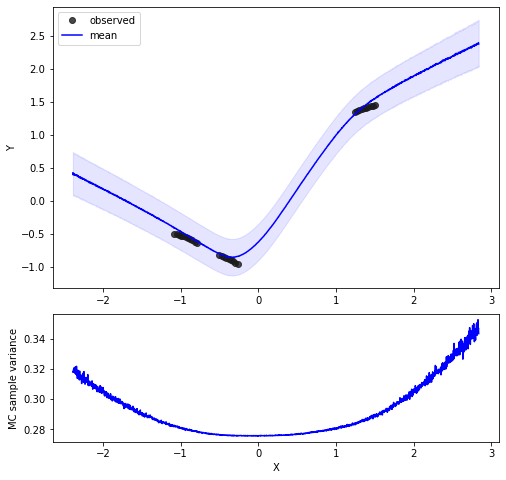

In [3062]:
plt.close("all")
plt.clf()
fig = plt.figure(figsize=(8, 8))
ax0 = plt.subplot2grid((3,1), (0, 0), rowspan=2)
ax1 = plt.subplot2grid((3,1), (2, 0))
losses = []
for i in trange(10000):
    loss = fit_model(model, optimizer)
    losses.append(loss.data.numpy())
print("loss={}".format(loss))

y_mean, y_std = uncertainity_estimate(X_true, model, 1000, l2)

ax0.plot(X_obs, y_obs, ls="none", marker="o", color="0.1", alpha=0.8, label="observed")
ax0.plot(X_true, y_mean, ls="-", color="b", label="mean")

'''
for i in range(2):
    ax0.fill_between(
        X_true,
        y_mean - y_std * ((i+1.)/2.),
        y_mean + y_std * ((i+1.)/2.),
        color="b",
        alpha=0.1
    )
'''
ax0.fill_between(
    X_true,
    y_mean - y_std,
    y_mean + y_std,
    color="b",
    alpha=0.1
)
ax0.legend()
#ax1.plot(losses, ls="-", lw=1, alpha=0.5)
ax1.plot(X_true, y_std, ls="-", color="b", label="mean")
ax0.set_ylabel("Y")
ax1.set_ylabel("MC sample variance")
ax1.set_xlabel("X")
plt.savefig('drop_part.pdf')

Optimization restart 1/10, f = -104.16634774047418
Optimization restart 2/10, f = -104.16634777911747
Optimization restart 3/10, f = -104.16634777146007
Optimization restart 4/10, f = -104.1663477756023
Optimization restart 5/10, f = -104.16634777764926
Optimization restart 6/10, f = -104.16634777892966
Optimization restart 7/10, f = -104.16634777587294
Optimization restart 8/10, f = -104.16634777211888
Optimization restart 9/10, f = -104.1663477781008
Optimization restart 10/10, f = -104.1663477757784


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0002  -1.041663e+02   2.608145e-10 
Runtime:     00s00
Optimization status: Converged



(-2.6, 3.1)

{'dataplot': [<matplotlib.collections.PathCollection at 0x7f75098bc4c0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7f7509907fd0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7f75098f9220>]}

Text(0, 0.5, 'Y')

Text(0, 0.5, 'posterior variance')

Text(0.5, 0, 'X')

<Figure size 432x288 with 0 Axes>

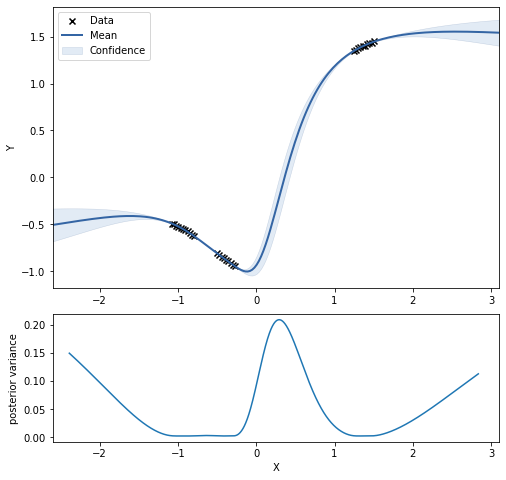

In [3064]:
kernel = GPy.kern.MLP(input_dim=1)
m1 = GPy.models.GPRegression(np.expand_dims(X_obs, axis=1), np.expand_dims(y_obs, axis=1),kernel =kernel)
m1.optimize_restarts(num_restarts = 10)
m1.optimize(messages=True)

import matplotlib
matplotlib.use("Agg")
GPy.plotting.change_plotting_library("matplotlib")

plt.close("all")
plt.clf()
fig = plt.figure(figsize=(8, 8))
ax0 = plt.subplot2grid((3,1), (0, 0), rowspan=2)
ax1 = plt.subplot2grid((3,1), (2, 0))
ax1.set_xlim(-2.6,3.1)
m1.plot(ax=ax0,plot_limits = [-2.6,3.1],lower=15.9, upper=84.1)
#ax0 = ax_custom['dataplot'][0]
mean, var = m1.predict(np.expand_dims(X_true, axis=1))
ax1.plot(X_true,np.sqrt(var))
ax0.set_ylabel("Y")
ax1.set_ylabel("posterior variance")
ax1.set_xlabel("X")
plt.savefig("gp_part.pdf")